In [4]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import seaborn as sns

In [5]:
sns.set_theme(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'

In [6]:
raw = pd.read_csv("http://hilpisch.com/tr_eikon_eod_data.csv", index_col=0, parse_dates=True)

In [7]:
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [8]:
symbol = 'EUR=' # EUR/USD

In [9]:
data = pd.DataFrame(raw[symbol])

In [10]:
data.head()

,EUR=
Date,
2010-01-01,1.4323
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318


In [11]:
data['returns'] = np.log(data / data.shift(1))

In [12]:
data.dropna(inplace=True)

In [13]:
data['direction'] = np.sign(data['returns']).astype(int)

In [14]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


<Axes: >

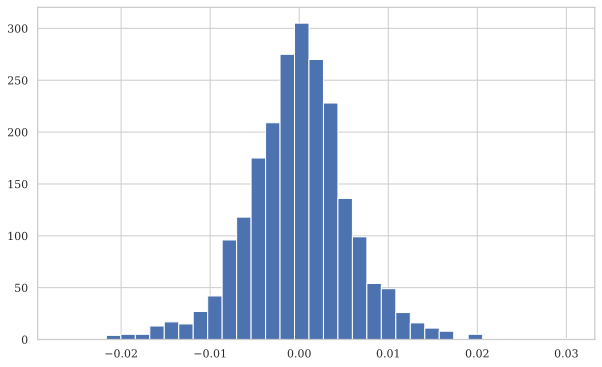

In [15]:
data['returns'].hist(bins=35, figsize=(10,6))

In [16]:
def create_lags(data, lags):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        data[col] = data['returns'].shift(lag)
        cols.append(col)
    

In [17]:
create_lags(data, 2)

In [18]:
data.dropna(inplace=True)
data[cols].head()

,lag_1,lag_2
Date,,
2010-01-06,-0.002988,0.006125
2010-01-07,0.003058,-0.002988
2010-01-08,-0.006544,0.003058
2010-01-11,0.006544,-0.006544
2010-01-12,0.006984,0.006544


## Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
model = LinearRegression()

In [21]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [22]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [23]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-0.000002,-0.000663
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-0.000164,0.001545
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,0.000030,0.032971
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-0.000245,-0.004227
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.000154,-0.061068


In [24]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [25]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-1,-1
2010-01-07,-1,1
2010-01-08,1,1
2010-01-11,-1,-1
2010-01-12,-1,-1


In [26]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1863
 1     350
Name: count, dtype: int64

In [27]:
data['pos_ols_2'].value_counts()

pos_ols_2
 1    1310
-1     903
Name: count, dtype: int64

## Backtesting

In [28]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [29]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [30]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
Date,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310


In [31]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.813126
strat_ols_1    0.987177
strat_ols_2    1.287336
dtype: float64

## K-Means Clustering

In [32]:
from sklearn.cluster import KMeans

In [33]:
model = KMeans(n_clusters=2, random_state=0)

In [34]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [35]:
data['pos_clus'] = model.predict(data[cols])

In [36]:
data['pos_clus'].head()

Date
2010-01-06    1
2010-01-07    0
2010-01-08    0
2010-01-11    0
2010-01-12    1
Name: pos_clus, dtype: int32

In [37]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

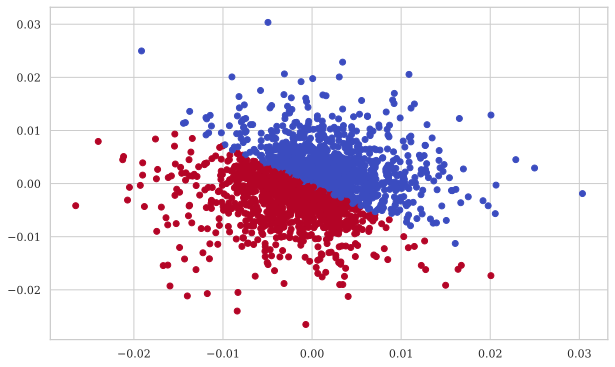

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm')

In [39]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [40]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.813126
strat_clus    1.096448
dtype: float64

<Axes: xlabel='Date'>

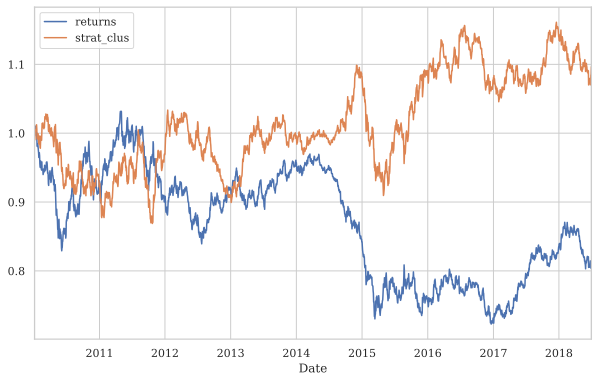

In [41]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10,6))

## Classification Algorithms

### Two Binary Features

In [42]:
from sklearn import linear_model # logistric regression
from sklearn.naive_bayes import GaussianNB # GNB
from sklearn.svm import SVC # SVM

In [43]:
models = {
    'log_reg': linear_model.LogisticRegression(C=1), # C is regularization hyperparameter (control overfitting)
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=1)
    }

In [44]:
def fit_models(data):
    mfit = { model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys() }

In [48]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [49]:
create_bins(data)
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus,lag_1_bin,lag_2_bin
Date,,,,,,,,,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125,-1,-1,-0.003058,-0.003058,-1,-0.003058,0,1
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,1,0.006544,-0.006544,1,-0.006544,1,0
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544,1,0.006544,0,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984,1,0.006984,1,0
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310,-1,0.001310,1,1


In [50]:
fit_models(data)

In [51]:
def derivate_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [52]:
derivate_positions(data)

In [53]:
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
    

In [54]:
evaluate_strats(data)

In [55]:
data[sel].sum().apply(np.exp)

returns           0.813126
strat_log_reg     1.385460
strat_gauss_nb    1.385460
strat_svm         1.016673
dtype: float64

<Axes: xlabel='Date'>

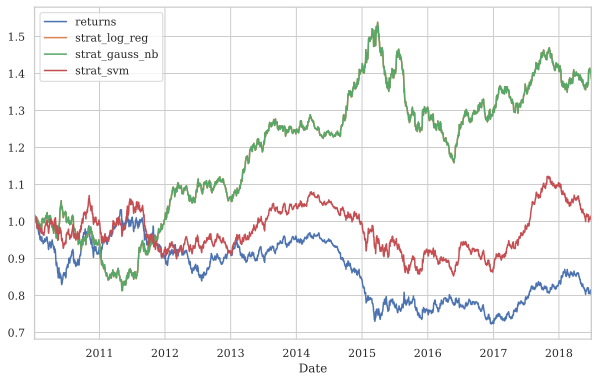

In [56]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

### Five Binary Feature

In [57]:
data = pd.DataFrame(raw[symbol])

In [58]:
data['returns'] = np.log(data / data.shift(1))

In [59]:
data['direction'] = np.sign(data['returns'])

In [60]:
lags = 5
create_lags(data, lags)

In [61]:
data.dropna(inplace=True)

In [62]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544


In [63]:
create_bins(data)

In [64]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,,,,,,,,,
2010-01-11,1.4513,0.006984,1.0,0.006544,-0.006544,0.003058,-0.002988,0.006125,1,0,1,0,1
2010-01-12,1.4494,-0.001310,-1.0,0.006984,0.006544,-0.006544,0.003058,-0.002988,1,1,0,1,0
2010-01-13,1.4510,0.001103,1.0,-0.001310,0.006984,0.006544,-0.006544,0.003058,0,1,1,0,1
2010-01-14,1.4502,-0.000551,-1.0,0.001103,-0.001310,0.006984,0.006544,-0.006544,1,0,1,1,0
2010-01-15,1.4382,-0.008309,-1.0,-0.000551,0.001103,-0.001310,0.006984,0.006544,0,1,0,1,1


In [65]:
data.dropna(inplace=True)

In [66]:
fit_models(data)

In [67]:
derivate_positions(data)

In [68]:
evaluate_strats(data)

In [69]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
strat_svm         2.364393
dtype: float64

<Axes: xlabel='Date'>

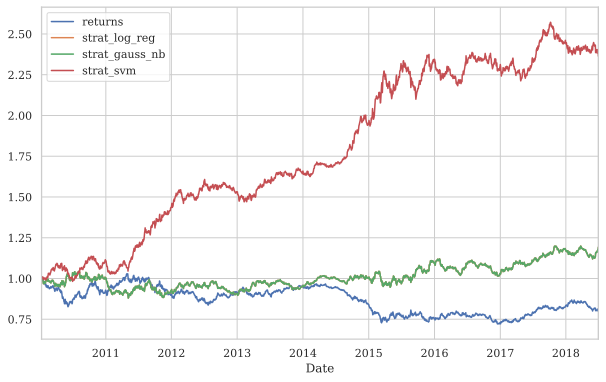

In [70]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

In [71]:
mu = data['returns'].mean()

In [72]:
v = data['returns'].std()

In [73]:
bins = [mu - v, mu, mu + v]

In [74]:
bins

[-0.005924269398870447, -9.498932088272977e-05, 0.0057342907571049885]

In [75]:
create_bins(data, bins)

In [76]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3


In [77]:
fit_models(data)

In [78]:
derivate_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.483957
strat_gauss_nb    1.437281
strat_svm         5.815787
dtype: float64

<Axes: xlabel='Date'>

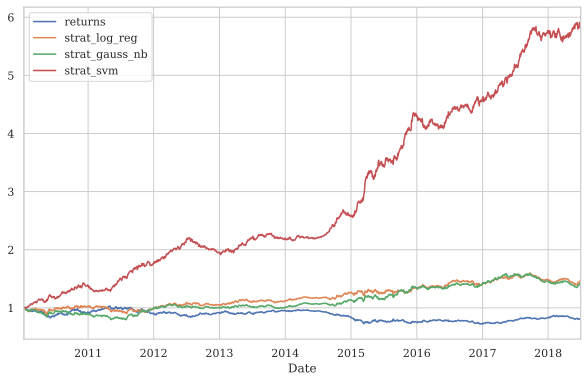

In [79]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

## Sequential Train-Test Split

In [80]:
split = int(len(data) * 0.5)

In [81]:
train = data.iloc[:split].copy()

In [82]:
fit_models(train)

In [83]:
test = data.iloc[split:].copy()

In [84]:
evaluate_strats(test)

In [85]:
test[sel].sum().apply(np.exp)

returns           0.852649
strat_log_reg     1.268778
strat_gauss_nb    1.346090
strat_svm         2.625820
dtype: float64

<Axes: xlabel='Date'>

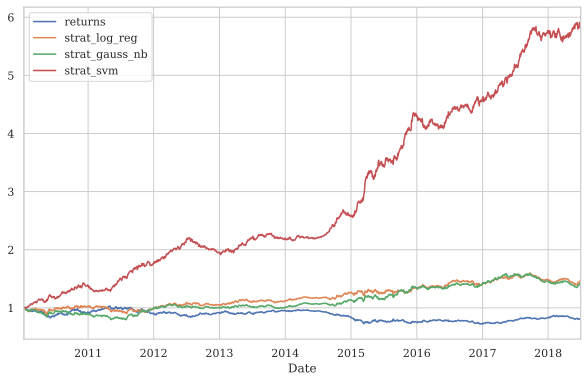

In [86]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

## Randomized Train-Test Split

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
train, test = train_test_split(data, test_size=0.5, shuffle=True, random_state=100)

In [90]:
train = train.copy().sort_index()

In [91]:
train[cols_bin].head(10)

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-18,0,1,2,1,3
2010-01-19,2,0,1,2,1
2010-01-20,0,2,0,1,2
2010-01-26,2,2,1,0,0
2010-01-28,1,1,2,2,1


In [92]:
test = test.copy().sort_index()

In [93]:
fit_models(train)
derivate_positions(test)
evaluate_strats(test)
test[sel].sum().apply(np.exp)

returns           0.736500
strat_log_reg     0.788983
strat_gauss_nb    1.010429
strat_svm         1.148902
dtype: float64

<Axes: xlabel='Date'>

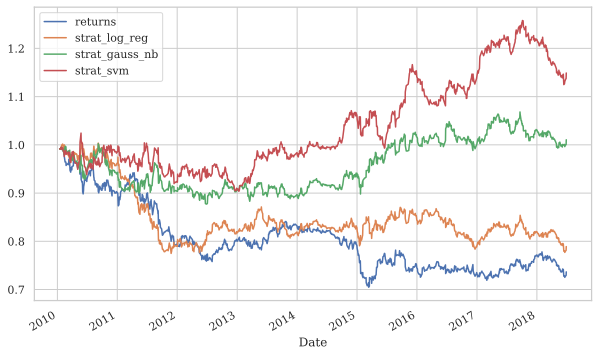

In [94]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6))